## Ejercicio 1

Crea almenys tres models de classificació diferents per intentar predir el millor possible l’endarreriment dels vols (ArrDelay) de DelayedFlights.csv. Considera si el vol ha arribat tard o no (ArrDelay > 0).

## Exercici 2

Compara els models de classificació utilitzant la precisió (accuracy), una matriu de confiança i d’altres mètriques més avançades.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Configuracion para que se mestren todas las columnas
pd.set_option('display.max_columns', None)
# Configuracion para que los valores no se muestren con punto flotante
pd.options.display.float_format = '{:,.2f}'.format
# Lectura del fichero
df = pd.read_csv('DelayedFlights.csv')

# Normalizacion de los nombres de la columnas
df.columns = [col.lower() for col in df]

df.rename(columns={
    'dayofmonth': 'day_of_month', 
    'dayofweek': 'day_of_week',
    'crsdeptime': 'crs_dep_time',
    'crsarrtime': 'crs_arr_time',
    'uniquecarrier': 'unique_carrier',
    'actualelapsedtime': 'actual_elapsed_time',
    'crselapsedtime': 'crs_elapsed_time',
    'airtime': 'air_time',
    'arrdelay': 'arr_delay',
    'depdelay': 'dep_delay',
    'taxiout': 'taxi_out',
    'taxiin': 'taxi_in',
    'cancellationcode': 'cancellation_code',
    'carrierdelay': 'carrier_delay',
    'weatherdelay': 'weather_delay',
    'nasdelay': 'nas_delay',
    'securitydelay': 'security_delay',
    'lateaircraftdelay': 'late_air_craft_delay',
    'deptime': 'dep_time',
    'arrtime': 'arr_time',
    'tailnum': 'tail_num',
    'flightnum': 'flight_num'
    }, inplace=True)

# Eliminación de columnas
del df['tail_num']
del df['taxi_in']
del df['taxi_out']
del df['cancellation_code']
del df['year']

df.fillna({'arr_delay':0}, inplace=True)
df.fillna({'carrier_delay':0, 'late_air_craft_delay':0}, inplace=True)

In [2]:
# Se agrega columna que indica si el vuelo ha llegado tarde o no
def arrived_late(row):
    if row['arr_delay'] > 0:
        return 1
    return 0

df['arr_late'] = df.apply(arrived_late, axis = 1)

Analicemos cómo se correlacionan las variables con nuestra variable objetivo, **arr_late**

In [3]:
df.corr()

,unnamed: 0,month,day_of_month,day_of_week,dep_time,crs_dep_time,arr_time,crs_arr_time,flight_num,actual_elapsed_time,crs_elapsed_time,air_time,arr_delay,dep_delay,distance,cancelled,diverted,carrier_delay,weather_delay,nas_delay,security_delay,late_air_craft_delay,arr_late
unnamed: 0,1.00,1.00,0.06,-0.00,-0.01,-0.01,-0.00,0.00,-0.02,0.03,0.03,0.02,0.00,0.01,0.03,0.03,0.01,-0.00,0.01,0.02,-0.00,-0.00,-0.02
month,1.00,1.00,0.06,0.00,-0.01,-0.01,0.00,0.00,-0.00,0.00,0.01,0.00,-0.00,0.00,0.01,0.03,0.01,-0.00,0.01,0.01,-0.00,-0.00,-0.02
day_of_month,0.06,0.06,1.00,0.02,0.00,0.00,0.00,0.00,-0.01,-0.00,-0.00,-0.00,0.00,0.01,0.00,0.00,0.00,-0.00,0.00,0.01,-0.00,0.01,-0.00
day_of_week,-0.00,0.00,0.02,1.00,0.02,0.03,0.01,0.02,-0.01,0.00,0.00,0.00,0.01,0.01,0.01,0.00,-0.00,0.01,0.01,-0.01,0.00,0.01,-0.01
dep_time,-0.01,-0.01,0.00,0.02,1.00,0.88,0.46,0.71,-0.02,-0.05,-0.04,-0.05,0.13,0.14,-0.06,0.00,-0.00,-0.01,0.01,0.02,-0.02,0.17,0.06
crs_dep_time,-0.01,-0.01,0.00,0.03,0.88,1.00,0.40,0.71,-0.05,-0.03,-0.03,-0.04,0.04,0.06,-0.03,0.00,-0.01,-0.07,-0.01,-0.03,-0.02,0.15,0.04
arr_time,-0.00,0.00,0.00,0.01,0.46,0.40,1.00,0.62,-0.01,-0.01,-0.01,-0.02,-0.05,-0.05,-0.03,nan,-0.01,-0.07,-0.03,0.03,-0.01,-0.03,0.00
crs_arr_time,0.00,0.00,0.00,0.02,0.71,0.71,0.62,1.00,-0.06,0.03,0.04,0.03,0.04,0.05,0.02,0.00,0.00,-0.06,-0.01,0.01,-0.01,0.12,0.02
flight_num,-0.02,-0.00,-0.01,-0.01,-0.02,-0.05,-0.01,-0.06,1.00,-0.32,-0.34,-0.34,0.06,0.05,-0.36,0.01,-0.00,0.06,0.07,0.02,-0.00,-0.02,0.06
actual_elapsed_time,0.03,0.00,-0.00,0.00,-0.05,-0.03,-0.01,0.03,-0.32,1.00,0.97,0.98,0.07,0.02,0.95,nan,nan,0.02,0.00,0.18,0.01,-0.01,-0.06


Vemos que las que tienen un poco de correlación son las variables **late_air_craft_delay**, **carrier_delay** y **dep_delay**

Tomamos las columnas que nos interezan.

In [4]:
df_arr_delay = df[['dep_delay','carrier_delay', 'late_air_craft_delay', 'arr_late']]

Analicemos cómo es nuestra variable objetivo.

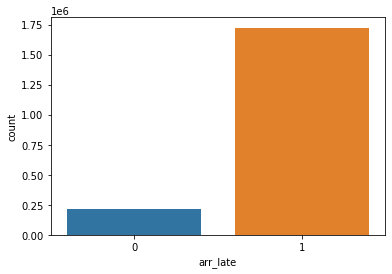

In [5]:
ax = sns.countplot(x = "arr_late", data = df_arr_delay)

In [6]:
df_arr_delay['arr_late'].value_counts()

1    1723415
0     213343
Name: arr_late, dtype: int64

Podemos observar que hay un debalanceo de los datos de la variable, esto puede afectar las predicciones de los modelos. Luego lo analizaremos.

Pre procesamos los datos.

In [7]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_transformed = df_arr_delay.copy()
X_train_minmax = min_max_scaler.fit_transform(X_train_transformed[["dep_delay",'carrier_delay','late_air_craft_delay']])
scaled_features_df = pd.DataFrame(X_train_minmax, index=X_train_transformed.index, columns=["dep_delay",'carrier_delay','late_air_craft_delay'])
X_train_transformed["dep_delay"] = scaled_features_df["dep_delay"]
X_train_transformed['carrier_delay'] = scaled_features_df['carrier_delay']
X_train_transformed['late_air_craft_delay'] = scaled_features_df['late_air_craft_delay']
X_train_transformed.describe()

,dep_delay,carrier_delay,late_air_craft_delay,arr_late
count,"1,936,758.00","1,936,758.00","1,936,758.00","1,936,758.00"
mean,0.02,0.01,0.01,0.89
std,0.02,0.01,0.03,0.31
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,1.00
50%,0.01,0.00,0.00,1.00
75%,0.02,0.00,0.01,1.00
max,1.00,1.00,1.00,1.00


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_train_transformed[['dep_delay','carrier_delay','late_air_craft_delay']], X_train_transformed['arr_late'], test_size=0.30)

Ya tenemos nuestros juntos preparados para utilizar los modelos.

### Primer modelo: Decision Tree Classification.

In [9]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_dtc_train_pred = dtc.predict(X_train)
metrics.accuracy_score(y_train, y_dtc_train_pred)

0.889888104563593

In [10]:
y_dtc_test_pred = dtc.predict(X_test)
metrics.accuracy_score(y_test, y_dtc_test_pred)

0.8897436956566637

Tanto con el conjunto de entrenamiento como el de test, el algoritmo ha devuelto un buen valor de accuracy con un 88%. Veamos la matriz de confusión y otras métricas.

In [11]:
dtc_cm = metrics.confusion_matrix(y_test, y_dtc_test_pred)
print(dtc_cm)

[[     2  64043]
 [    19 516964]]


<AxesSubplot:>

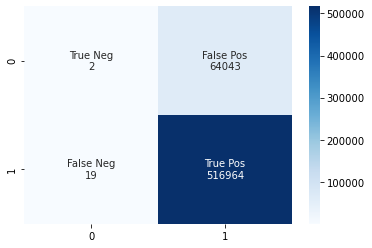

In [12]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = dtc_cm.flatten()
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(dtc_cm, annot=labels, fmt='', cmap='Blues')

In [13]:
report = metrics.classification_report(y_test, y_dtc_test_pred, digits=3, output_dict = True)
print("Accuracy = {0:0.3f}".format(report["accuracy"]))
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Sensitivity-Recall = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

Accuracy = 0.890
Precision = 0.890
Sensitivity-Recall = 1.000
F1-score = 0.942


Podemos ver que hay unos casos de falsos negativos, pero para este caso no es tan grave. Por otro lado tenemos buenos valores de Precision, Accuracy y Recall. Pero tambien hay muchos falsos positivos.

### Segundo modelo: Logistic Regression

In [14]:
rl = LogisticRegression()
rl.fit(X_train, y_train)
y_rl_train_pred = rl.predict(X_train)
metrics.accuracy_score(y_train, y_rl_train_pred)

0.8898763028036556

In [15]:
y_lr_test_pred = rl.predict(X_test)
metrics.accuracy_score(y_test, y_lr_test_pred)

0.8897729541433459

In [16]:
lr_cm = metrics.confusion_matrix(y_test, y_lr_test_pred)
print(lr_cm)

[[     0  64045]
 [     0 516983]]


<AxesSubplot:>

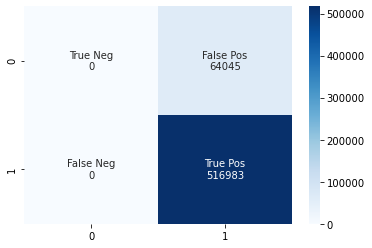

In [17]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = lr_cm.flatten()
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lr_cm, annot=labels, fmt='', cmap='Blues')

In [18]:
report = metrics.classification_report(y_test, y_lr_test_pred, digits=3, output_dict = True)
print("Accuracy = {0:0.3f}".format(report["accuracy"]))
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Sensitivity-Recal = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy = 0.890
Precision = 0.890
Sensitivity-Recal = 1.000
F1-score = 0.942


Con el modelo Logistic Regression obtuvimos métricas similares que el primer modelo, aunque en este caso no tenemos nigún true negative, es decir que no acertó ningun caso de no retraso, y ningún falso negativo. Este modelo no pudo predecir ningún caso de un vuelo que no vaya a retrasarse.

### Tercer modelo: XGboost

In [19]:
xgbc = xgb.XGBClassifier()
xgbc.fit(X_train, y_train)
y_xgbc_train_pred = xgbc.predict(X_train)
metrics.accuracy_score(y_train, y_xgbc_train_pred)

C:\Users\Ale\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:51:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8898822036836244

In [20]:
y_xgbc_test_pred = xgbc.predict(X_test)
metrics.accuracy_score(y_test, y_xgbc_test_pred)

0.889771233055894

In [21]:
xgbc_cm = metrics.confusion_matrix(y_test, y_xgbc_test_pred)
print(xgbc_cm)

[[     0  64045]
 [     1 516982]]


<AxesSubplot:>

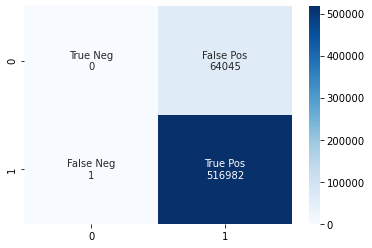

In [22]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = xgbc_cm.flatten()
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(xgbc_cm, annot=labels, fmt='', cmap='Blues')

In [23]:
report = metrics.classification_report(y_test, y_xgbc_test_pred, digits=3, output_dict = True)
print("Accuracy = {0:0.3f}".format(report["accuracy"]))
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Sensitivity-Recall = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

Accuracy = 0.890
Precision = 0.890
Sensitivity-Recall = 1.000
F1-score = 0.942


Con el modelo xgboost obtuvimos resultados similares al de Logistic Regression.

Los 3 modelos tuvieron métricas similares, pero Logistic Regression es el que tuvo menos falsos negativos. Sin embargo, los 3 modelos tuvieron grandes cantidades de falsos positivos. Esto puede ser por el desbalanceo de los datos.  Lo analizaremos en los siguientes ejercicios.

## Exercici 3

Entrena’ls utilitzant els diferents paràmetres que admeten.

## Exercici 4

Compara el seu rendiment utilitzant l’aproximació traint/test o cross-validation.

### Modelo Decision Tree Classification

Para el caso de Decision Tree usamemos el Hyper parameter class_weight para compenzar el desbalanceo. Como tenemos menor cantidad de vuelos sin retrasos, le asignamos un peso de 8 a esa etiqueta. Ese valor es el resultado de la división de cantidad de vuelos retrasados (1723415) por los no retrasados (213343). También veremos cuál es el valor de profundidad que nos da mayor accuracy utilzando cross validation.

In [24]:
skf = StratifiedKFold(n_splits=5)
X_df = X_train_transformed[['dep_delay','carrier_delay','late_air_craft_delay']]
target = X_train_transformed.loc[:,'arr_late']
accuracies = list()
precision = list()
recall = list()
accuracies = list()
depth_range = range(1, 7)

for depth in depth_range:
    fold_accuracy = []
    fold_precision = []
    fold_recall = []

    tree_model = DecisionTreeClassifier(criterion='entropy',
                                             max_depth = depth,
                                             class_weight={0:8.07})
    
    for train_index, test_index in skf.split(X_df, target):
        X_train_fold, X_test_fold = X_df.loc[train_index], X_df.loc[test_index]
        y_train_fold, y_test_fold = target.loc[train_index], target.loc[test_index]
        
        tree_model.fit(X_train_fold, y_train_fold)
        valid_acc = tree_model.score(X=X_test_fold, y=y_test_fold) 
        fold_accuracy.append(valid_acc)
        
        y_tree_test_pred_fold = tree_model.predict(X_test_fold)
        report = metrics.classification_report(y_test_fold, y_tree_test_pred_fold, digits=3, output_dict = True)
        fold_precision.append(report["1"]["precision"])
        fold_recall.append(report["1"]["recall"])

    avg = sum(fold_accuracy)/len(fold_accuracy)
    avg_precision = sum(fold_precision)/len(fold_precision)
    avg_recall = sum(fold_recall)/len(fold_recall)
    accuracies.append(avg)
    precision.append(avg_precision)
    recall.append(avg_recall)

df_tree = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies, "Average Precision": precision, "Average Recall": recall})
df_tree = df_tree[["Max Depth", "Average Accuracy", "Average Precision", "Average Recall"]]
print(df_tree.to_string(index=False))

 Max Depth  Average Accuracy  Average Precision  Average Recall
         1              0.68               0.98            0.65
         2              0.74               0.99            0.72
         3              0.78               0.99            0.76
         4              0.78               0.99            0.76
         5              0.75               0.99            0.72
         6              0.75               0.99            0.72


Vemos que con 3 y 4 niveles de profundidad obtenemos el máximo de Accuracy, y valores similares de Precision Y recall. Por lo que la profundidad obtima sera de 3.

### Modelo Logistic Regression

Para el caso de LogisticRegression usamemos también el Hyper parameter class_weight

In [25]:
lRegr2 = LogisticRegression(class_weight={0:8.07}, solver = 'saga', max_iter = 300)
lRegr2.fit(X_train, y_train)
y_log_train_pred2 = lRegr2.predict(X_train)
metrics.accuracy_score(y_train, y_log_train_pred2)

0.6945734032587609

In [26]:
y_log_test_pred2 = lRegr2.predict(X_test)
metrics.accuracy_score(y_test, y_log_test_pred2)

0.694852915866361

In [27]:
lr_cm2 = metrics.confusion_matrix(y_test, y_log_test_pred2)
print(lr_cm2)

[[ 62902   1143]
 [176156 340827]]


<AxesSubplot:>

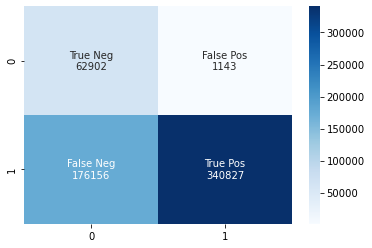

In [28]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = lr_cm2.flatten()
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lr_cm2, annot=labels, fmt='', cmap='Blues')

In [29]:
report = metrics.classification_report(y_test, y_log_test_pred2, digits=3, output_dict = True)
print("Accuracy = {0:0.3f}".format(report["accuracy"]))
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Sensitivity-Recall = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

Accuracy = 0.695
Precision = 0.997
Sensitivity-Recall = 0.659
F1-score = 0.794


En este caso vemos valores un poco más reales, a diferencia de la primera vez, tenemos casos de True Negative y buena cantidad de True Positive. También tenemos menos cantidad de falsos positivos. Tenemos más de falsos negativos pero no es tan grave para este caso.

### Modelo XGboost

Para XGboost haremos la misma mecanica de asignar profundidad y el cambiar el balanceo.

In [30]:
skf = StratifiedKFold(n_splits=5)
X_df = X_train_transformed[['dep_delay','carrier_delay','late_air_craft_delay']]
target = X_train_transformed.loc[:,'arr_late']
accuracies = list()
precision = list()
recall = list()
accuracies = list()
depth_range = range(1, 4)

for depth in depth_range:
    fold_accuracy = []
    fold_precision = []
    fold_recall = []
    
    xgbc = xgb.XGBClassifier(booster='gbtree', max_depth = depth, scale_pos_weight=0.125)

    for train_index, test_index in skf.split(X_df, target):
        X_train_fold, X_test_fold = X_df.loc[train_index], X_df.loc[test_index]
        y_train_fold, y_test_fold = target.loc[train_index], target.loc[test_index]
        
        xgbc.fit(X_train_fold, y_train_fold)
        valid_acc = xgbc.score(X=X_test_fold, y=y_test_fold) 
        fold_accuracy.append(valid_acc)
        
        y_tree_test_pred_fold = xgbc.predict(X_test_fold)
        report = metrics.classification_report(y_test_fold, y_tree_test_pred_fold, digits=3, output_dict = True)
        fold_precision.append(report["1"]["precision"])
        fold_recall.append(report["1"]["recall"])

    avg = sum(fold_accuracy)/len(fold_accuracy)
    avg_precision = sum(fold_precision)/len(fold_precision)
    avg_recall = sum(fold_recall)/len(fold_recall)
    accuracies.append(avg)
    precision.append(avg_precision)
    recall.append(avg_recall)

df_xgbc = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies, "Average Precision": precision, "Average Recall": recall})
df_xgbc = df_xgbc[["Max Depth", "Average Accuracy", "Average Precision", "Average Recall"]]
print(df_xgbc.to_string(index=False))

C:\Users\Ale\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:56:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:56:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:57:38] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\Ale\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:59:21] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:00:47] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\Ale\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:02:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:03:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:04:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:04:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Obtuvimos valores similares que Decision Tree Classification, pero el modelo de Decision fue mucho más rápido, habría que experimentar con otros hyper parameters para ver si XGboost puede ser más rápido. 

Con las modificaciones realizadas, con el Decision Tree obtuvimos mejores resultados.

## Exercici 5

Realitza algun procés d’enginyeria de variables per millorar-ne la predicció

In [31]:
df.head(20)

,unnamed: 0,month,day_of_month,day_of_week,dep_time,crs_dep_time,arr_time,crs_arr_time,unique_carrier,flight_num,actual_elapsed_time,crs_elapsed_time,air_time,arr_delay,dep_delay,origin,dest,distance,cancelled,diverted,carrier_delay,weather_delay,nas_delay,security_delay,late_air_craft_delay,arr_late
0,0,1,3,4,"2,003.00",1955,"2,211.00",2225,WN,335,128.00,150.00,116.00,-14.00,8.00,IAD,TPA,810,0,0,0.00,nan,nan,nan,0.00,0
1,1,1,3,4,754.00,735,"1,002.00",1000,WN,3231,128.00,145.00,113.00,2.00,19.00,IAD,TPA,810,0,0,0.00,nan,nan,nan,0.00,1
2,2,1,3,4,628.00,620,804.00,750,WN,448,96.00,90.00,76.00,14.00,8.00,IND,BWI,515,0,0,0.00,nan,nan,nan,0.00,1
3,4,1,3,4,"1,829.00",1755,"1,959.00",1925,WN,3920,90.00,90.00,77.00,34.00,34.00,IND,BWI,515,0,0,2.00,0.00,0.00,0.00,32.00,1
4,5,1,3,4,"1,940.00",1915,"2,121.00",2110,WN,378,101.00,115.00,87.00,11.00,25.00,IND,JAX,688,0,0,0.00,nan,nan,nan,0.00,1
5,6,1,3,4,"1,937.00",1830,"2,037.00",1940,WN,509,240.00,250.00,230.00,57.00,67.00,IND,LAS,1591,0,0,10.00,0.00,0.00,0.00,47.00,1
6,10,1,3,4,706.00,700,916.00,915,WN,100,130.00,135.00,106.00,1.00,6.00,IND,MCO,828,0,0,0.00,nan,nan,nan,0.00,1
7,11,1,3,4,"1,644.00",1510,"1,845.00",1725,WN,1333,121.00,135.00,107.00,80.00,94.00,IND,MCO,828,0,0,8.00,0.00,0.00,0.00,72.00,1
8,15,1,3,4,"1,029.00",1020,"1,021.00",1010,WN,2272,52.00,50.00,37.00,11.00,9.00,IND,MDW,162,0,0,0.00,nan,nan,nan,0.00,1
9,16,1,3,4,"1,452.00",1425,"1,640.00",1625,WN,675,228.00,240.00,213.00,15.00,27.00,IND,PHX,1489,0,0,3.00,0.00,0.00,0.00,12.00,1


Podemos ver que las columnas de **_delay** tienen valores sólo cuando **arr_delay** es mayor o igual a 15. Analicemos cómo serían las métricas si consideramos arr_delay mayor or igual a 15 en lugar de 0.

In [32]:
# Se agrega columna que indica si el vuelo ha llegado tarde o no
def arrived_late(row):
    if row['arr_delay'] >= 15:
        return 1
    return 0

df['arr_late_15'] = df.apply(arrived_late, axis = 1)

In [33]:
df_arr_delay = df[['dep_delay','carrier_delay', 'late_air_craft_delay', 'arr_late_15']]

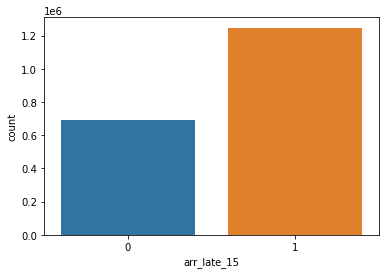

In [34]:
ax = sns.countplot(x = "arr_late_15", data = df_arr_delay)

In [35]:
df_arr_delay['arr_late_15'].value_counts()

1    1247488
0     689270
Name: arr_late_15, dtype: int64

De esta manera el modelo está un poco más balanceado que antes.

In [36]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_transformed = df_arr_delay.copy()
X_train_minmax = min_max_scaler.fit_transform(X_train_transformed[["dep_delay",'carrier_delay','late_air_craft_delay']])
scaled_features_df = pd.DataFrame(X_train_minmax, index=X_train_transformed.index, columns=["dep_delay",'carrier_delay','late_air_craft_delay'])
X_train_transformed["dep_delay"] = scaled_features_df["dep_delay"]
X_train_transformed['carrier_delay'] = scaled_features_df['carrier_delay']
X_train_transformed['late_air_craft_delay'] = scaled_features_df['late_air_craft_delay']
X_train_transformed.describe()

,dep_delay,carrier_delay,late_air_craft_delay,arr_late_15
count,"1,936,758.00","1,936,758.00","1,936,758.00","1,936,758.00"
mean,0.02,0.01,0.01,0.64
std,0.02,0.01,0.03,0.48
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,0.01,0.00,0.00,1.00
75%,0.02,0.00,0.01,1.00
max,1.00,1.00,1.00,1.00


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_train_transformed[['dep_delay','carrier_delay','late_air_craft_delay']], X_train_transformed['arr_late_15'], test_size=0.30)

In [38]:
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth = 3)
tree_model.fit(X_train, y_train)
y_dtc_train_pred3 = tree_model.predict(X_train)
metrics.accuracy_score(y_train, y_dtc_train_pred3)

0.9537149727453107

In [39]:
y_dtc_test_pred3 = tree_model.predict(X_test)
metrics.accuracy_score(y_test, y_dtc_test_pred3)

0.9537681488671802

In [40]:
dtc_cm3 = metrics.confusion_matrix(y_test, y_dtc_test_pred3)
print(dtc_cm3)

[[190955  15609]
 [ 11253 363211]]


<AxesSubplot:>

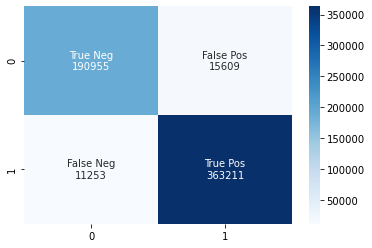

In [41]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = dtc_cm3.flatten()
labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(dtc_cm3, annot=labels, fmt='', cmap='Blues')

In [42]:
report = metrics.classification_report(y_test, y_dtc_test_pred3, digits=3, output_dict = True)
print("Accuracy = {0:0.3f}".format(report["accuracy"]))
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Sensitivity-Recall = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

Accuracy = 0.954
Precision = 0.959
Sensitivity-Recall = 0.970
F1-score = 0.964


Podemos ver que de esta forma tenemos más precisión y mayor recall que cuando armabamos la columna objetivo tiniendo en cuenta el **arr_delay** mayor que 0.

## Exercici 6

No utilitzis la variable DepDelay a l’hora de fer prediccions

In [43]:
# Lectura del fichero
df = pd.read_csv('DelayedFlights.csv')

# Normalizacion de los nombres de la columnas
df.columns = [col.lower() for col in df]

df.rename(columns={
    'dayofmonth': 'day_of_month', 
    'dayofweek': 'day_of_week',
    'crsdeptime': 'crs_dep_time',
    'crsarrtime': 'crs_arr_time',
    'uniquecarrier': 'unique_carrier',
    'actualelapsedtime': 'actual_elapsed_time',
    'crselapsedtime': 'crs_elapsed_time',
    'airtime': 'air_time',
    'arrdelay': 'arr_delay',
    'depdelay': 'dep_delay',
    'taxiout': 'taxi_out',
    'taxiin': 'taxi_in',
    'cancellationcode': 'cancellation_code',
    'carrierdelay': 'carrier_delay',
    'weatherdelay': 'weather_delay',
    'nasdelay': 'nas_delay',
    'securitydelay': 'security_delay',
    'lateaircraftdelay': 'late_air_craft_delay',
    'deptime': 'dep_time',
    'arrtime': 'arr_time',
    'tailnum': 'tail_num',
    'flightnum': 'flight_num'
    }, inplace=True)


# seleccion de columnas más importantes y limpeza de valores nulos
df_arr_delay = df[['carrier_delay', 'security_delay','nas_delay','weather_delay', 'late_air_craft_delay', 'arr_delay']]
df_arr_delay.fillna({'arr_delay':0}, inplace=True)
df_arr_delay.fillna({'carrier_delay':0, 'nas_delay':0, 'security_delay':0,'weather_delay':0,'late_air_craft_delay':0}, inplace=True)

C:\Users\Ale\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


Como no podemos utilizar **dep_delay**, utilizaremos la suma de **nas_delay**, **security_delay**, **weather_delay**, **late_air_craft_delay** y **carrier_delay**

In [44]:
# Se agrega columna que indica si el vuelo llegó tarde o no
def total_late(row):
    return row['carrier_delay'] + row['nas_delay'] + row['security_delay'] + row['weather_delay'] + row['late_air_craft_delay']

df_arr_delay['total_late'] = df_arr_delay.apply(total_late, axis = 1)

<ipython-input-44-0eb730082ab5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arr_delay['total_late'] = df_arr_delay.apply(total_late, axis = 1)


In [45]:
# Se agrega columna que indica si el vuelo ha llegado tarde o no
def arrived_late(row):
    if row['total_late'] > 0:
        return 1
    return 0

df_arr_delay['arr_late'] = df_arr_delay.apply(arrived_late, axis = 1)

<ipython-input-45-da8e43608b88>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arr_delay['arr_late'] = df_arr_delay.apply(arrived_late, axis = 1)


In [46]:
df_arr_delay = df_arr_delay[['total_late', 'arr_late']]

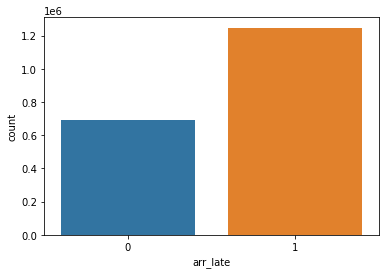

In [47]:
ax = sns.countplot(x = "arr_late", data = df_arr_delay)

Está más balanceado que tomando arr delay mayor que cero.

In [48]:
# Pre procesamiento
min_max_scaler = preprocessing.MinMaxScaler()
X_train_transformed = df_arr_delay.copy()
X_train_minmax = min_max_scaler.fit_transform(X_train_transformed[["total_late"]])
scaled_features_df = pd.DataFrame(X_train_minmax, index=X_train_transformed.index, columns=["total_late"])
X_train_transformed["total_late"] = scaled_features_df["total_late"]
X_train_transformed

,total_late,arr_late
0,0.00,0
1,0.00,0
2,0.00,0
3,0.01,1
4,0.00,0
...,...,...
1936753,0.01,1
1936754,0.03,1
1936755,0.04,1
1936756,0.00,0


In [49]:
X_data = X_train_transformed.copy()
del X_data['arr_late']
X_train, X_test, y_train, y_test = train_test_split(X_data, X_train_transformed['arr_late'], test_size=0.30)

In [50]:
X_train

,total_late
1331851,0.01
1597818,0.02
1108775,0.01
160782,0.01
409795,0.01
...,...
1745714,0.03
1487482,0.02
1210626,0.04
866372,0.03


In [51]:
tree_model = DecisionTreeClassifier(criterion='entropy', max_depth = 3)
tree_model.fit(X_train, y_train)
y_dtc_train_pred = tree_model.predict(X_train)
metrics.accuracy_score(y_train, y_dtc_train_pred)

1.0

In [52]:
y_dtc_test_pred = tree_model.predict(X_test)
metrics.accuracy_score(y_test, y_dtc_test_pred)

1.0

In [53]:
dtc_cm = metrics.confusion_matrix(y_test, y_dtc_test_pred)
print(dtc_cm)

[[206759      0]
 [     0 374269]]


<AxesSubplot:>

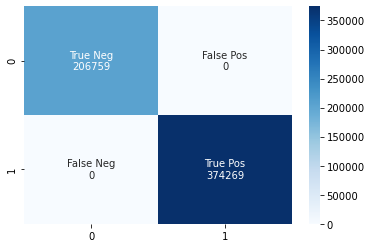

In [54]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = dtc_cm.flatten()
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(dtc_cm, annot=labels, fmt='', cmap='Blues')

In [55]:
report = metrics.classification_report(y_test, y_dtc_test_pred, digits=3, output_dict = True)
print("Accuracy = {0:0.3f}".format(report["accuracy"]))
print("Precision = {0:0.3f}".format(report["1"]["precision"]))
print("Sensitivity-Recall = {0:0.3f}".format(report["1"]["recall"]))
print("F1-score = {0:0.3f}".format(report["1"]["f1-score"]))

Accuracy = 1.000
Precision = 1.000
Sensitivity-Recall = 1.000
F1-score = 1.000


De esta forma podemos ver que tenemos un resultado mucho mejor, ningun falso positivo ni falso negativo.